In [1]:
import torch, glob, os
import numpy as np
import matplotlib.image as mpimg
from class_snapbot import Snapbot4EnvClass, Snapbot3EnvClass
from class_policy_gqvae_test import SnapbotTrajectoryUpdateClass
from class_grp import *
from utils import *

def eval_snapbot_from_network(env, embedding_num, dur_sec, n_anchor, max_repeat, folder, epoch,  condition, RENDER=False, PLOT=True):
    EvalPolicy = SnapbotTrajectoryUpdateClass(
                                                name = "EvalVQVAEPolicy",
                                                env  = env,
                                                out_min = -2,
                                                out_max = +2, 
                                                ANTIWU  = True,
                                                z_dim    = 32,
                                                c_dim    = 3,
                                                h_dims   = [128, 128],
                                                embedding_num = embedding_num,
                                                embedding_dim = 32,
                                                n_anchor = n_anchor,
                                                dur_sec  = dur_sec,
                                                max_repeat    = max_repeat,
                                                hyp_prior     = {'g': 1/1, 'l': 1/8, 'w': 1e-8},
                                                hyp_posterior = {'g': 1/4, 'l': 1/8, 'w': 1e-8},
                                                lbtw_base     = 0.8,
                                                device_idx = 0
                                                )
    ss_x_min  = -np.ones(env.adim)
    ss_x_max  = np.ones(env.adim)
    ss_margin = 0.1
    try:
        EvalPolicy.DLPG.load_state_dict(torch.load("dlpg/{}/weights/dlpg_model_weights_{}.pth".format(folder, epoch), map_location='cuda:0'))
    except:
        EvalPolicy.DLPG.load_state_dict(torch.load("dlpg/{}/weights/dlpg_model_weights_{}.pth".format(folder, epoch), map_location='cpu'))
    EvalPolicy.DLPG.eval()
    EvalPolicy.GRPPrior.set_prior(n_data_prior=4, dim=EvalPolicy.env.adim, dur_sec=dur_sec, HZ=EvalPolicy.env.hz, hyp=EvalPolicy.hyp_prior)
    traj_joints, traj_secs = EvalPolicy.GRPPrior.sample_one_traj(rand_type='Uniform', ORG_PERTURB=True, perturb_gain=0.0)
    t_anchor, _ = get_anchors_from_traj(traj_secs, traj_joints, n_anchor=EvalPolicy.n_anchor) 
    n_sample = 10
    for i in range(n_sample):
        x_anchor, codebook_idx = EvalPolicy.DLPG.sample_x(c=torch.FloatTensor(condition).reshape(1,-1).to(EvalPolicy.device), n_sample=1)
        x_anchor = x_anchor.reshape(EvalPolicy.n_anchor, EvalPolicy.env.adim)
        # codebook_idx = i
        # x_anchor = EvalPolicy.DLPG.sample_x_with_codebook_index(c=torch.FloatTensor(condition).reshape(1,-1).to(EvalPolicy.device), specify_idx=codebook_idx).reshape(-1, EvalPolicy.env.adim)
        x_anchor[-1,:] = x_anchor[0,:]
        EvalPolicy.GRPPosterior.set_posterior(t_anchor,x_anchor,lbtw=1.0,t_test=traj_secs,hyp=EvalPolicy.hyp_posterior,APPLY_EPSRU=True,t_eps=0.025)
        policy4eval_traj, traj_secs = EvalPolicy.GRPPosterior.sample_one_traj(rand_type='Uniform', ORG_PERTURB=True, perturb_gain=0.0, ss_x_min=ss_x_min,ss_x_max=ss_x_max,ss_margin=ss_margin)
        policy4eval_traj = scaleup_traj(EvalPolicy.env, policy4eval_traj, DO_SQUASH=False, squash_margin=5)
        t_anchor, x_anchor = get_anchors_from_traj(traj_secs, policy4eval_traj, n_anchor=EvalPolicy.n_anchor)  
        policy4eval  = rollout(EvalPolicy.env, EvalPolicy.PID, policy4eval_traj, n_traj_repeat=EvalPolicy.max_repeat, RENDER=RENDER, PLOT=PLOT)
        eval_reward  = sum(policy4eval['forward_rewards'])
        eval_x_diff  = policy4eval['x_diff']
        eval_secs    = policy4eval['secs']
        eval_figure  = policy4eval['figure']
        eval_xy_degs = policy4eval['xy_degs']
        # eval_figure.savefig('for_plot_{}'.format(i))
        # plt.close()
        plot_snapbot_joint_traj_and_topdown_traj(traj_secs, policy4eval_traj, t_anchor, x_anchor, eval_xy_degs, eval_secs,
                                                    figsize=(16,8), title_str="INDEX: {}, REWARD: {:>.1f} X_DIFF: {:>.3f}".format(codebook_idx, eval_reward, eval_x_diff), 
                                                    tfs=15, SAVE=False, image_name=None)
        print("INDEX: {}, REWARD: {:>.1f} X_DIFF: {:>.3f}".format(codebook_idx, eval_reward, eval_x_diff))
    return EvalPolicy

Snapbot(4legs) Environment
Obs Dim: [103] Act Dim: [8] dt:[0.02] Condition:[None]
ctrl_coef:[0] body_coef:[0] jump_coef:[0] vel_coef:[0] head_coef:[0]
EvalVQVAEPolicy START with DEVICE: cuda:0
INDEX: [7], REWARD: 154.3 X_DIFF: 3.085
INDEX: [29], REWARD: 125.8 X_DIFF: 2.516
INDEX: [18], REWARD: 114.9 X_DIFF: 2.299
INDEX: [21], REWARD: 69.3 X_DIFF: 1.386
INDEX: [21], REWARD: 99.8 X_DIFF: 1.996
INDEX: [4], REWARD: 156.4 X_DIFF: 3.127
INDEX: [13], REWARD: 152.6 X_DIFF: 3.053
INDEX: [6], REWARD: 57.3 X_DIFF: 1.131
INDEX: [22], REWARD: 136.8 X_DIFF: 2.735
INDEX: [8], REWARD: 135.7 X_DIFF: 2.714


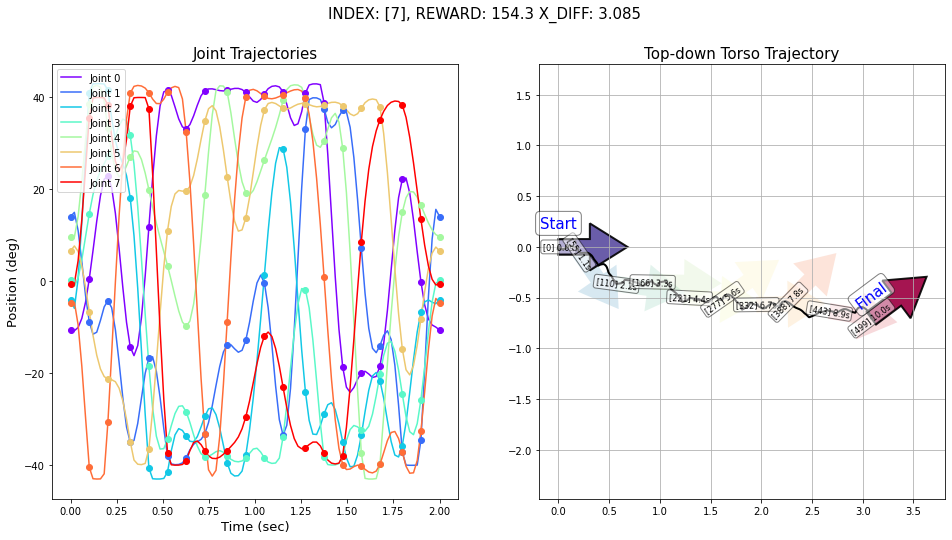

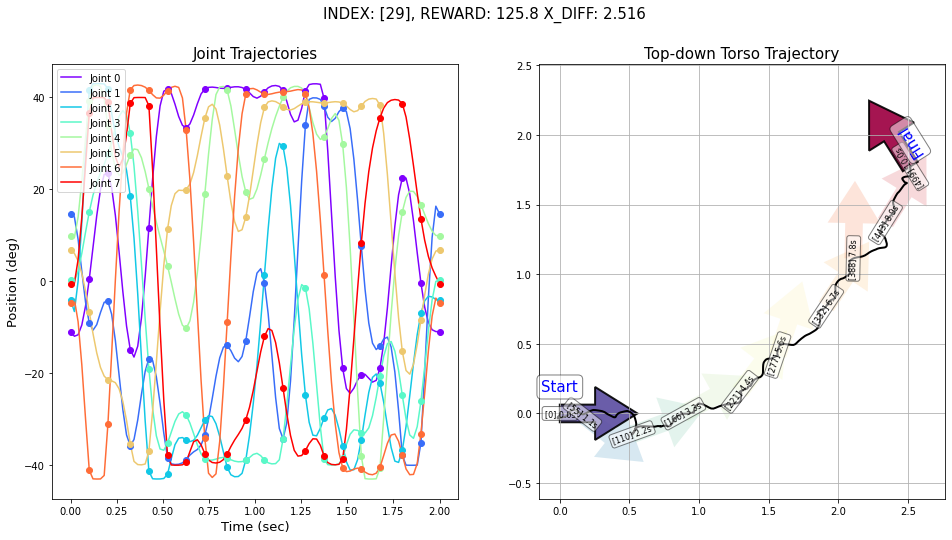

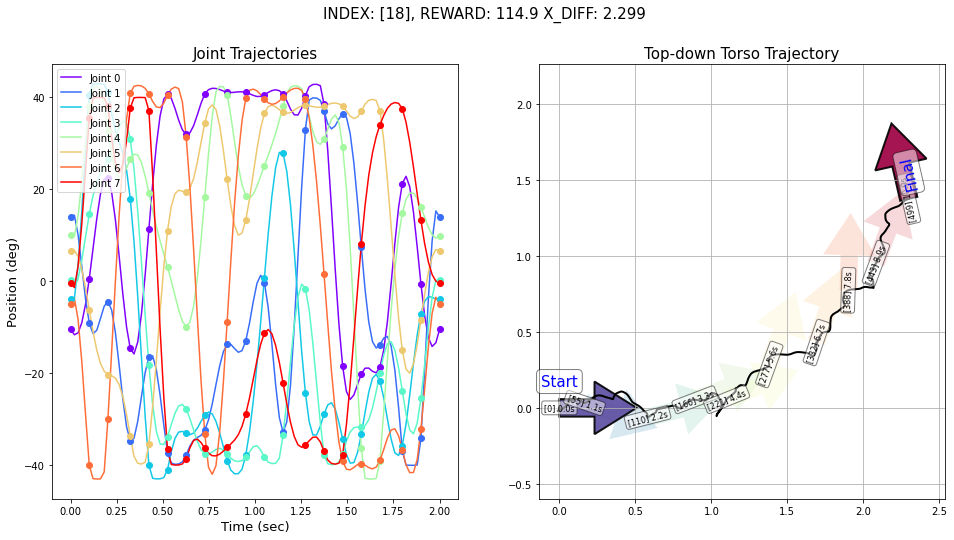

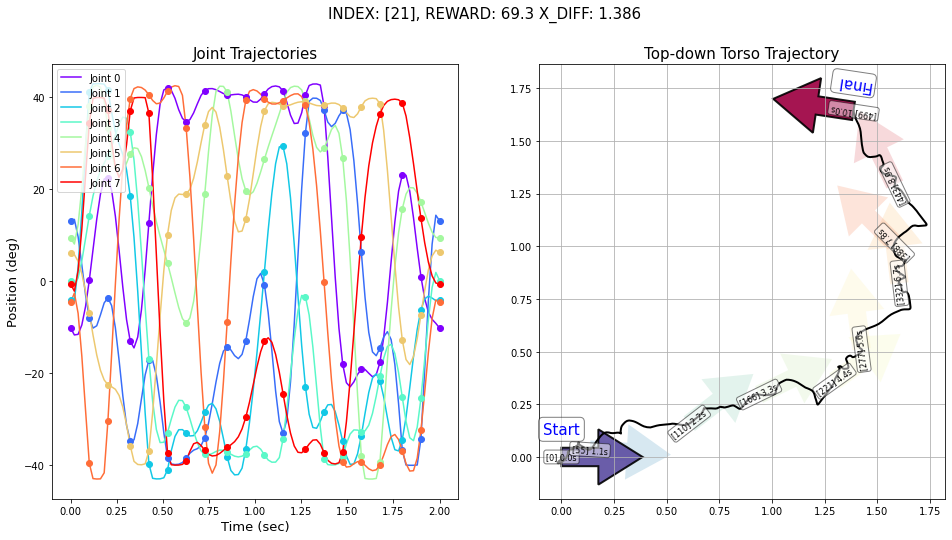

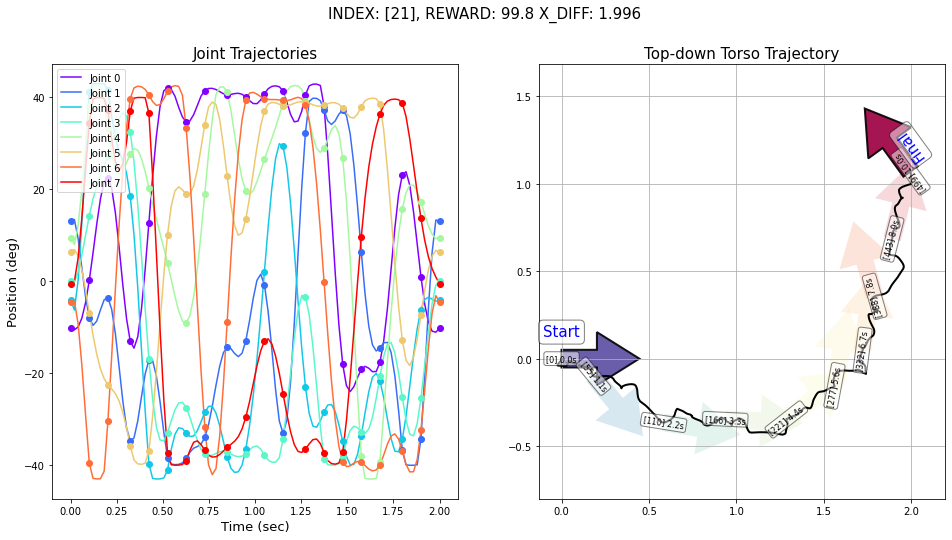

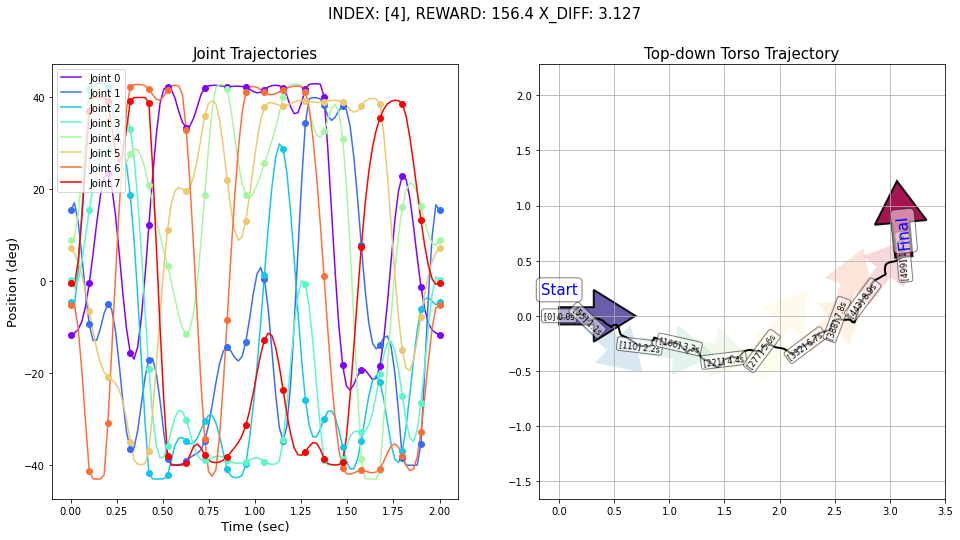

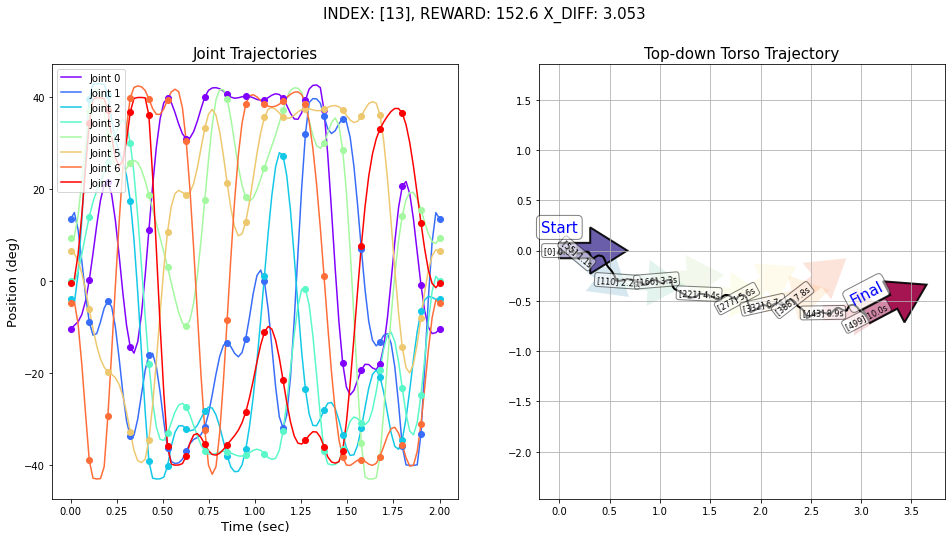

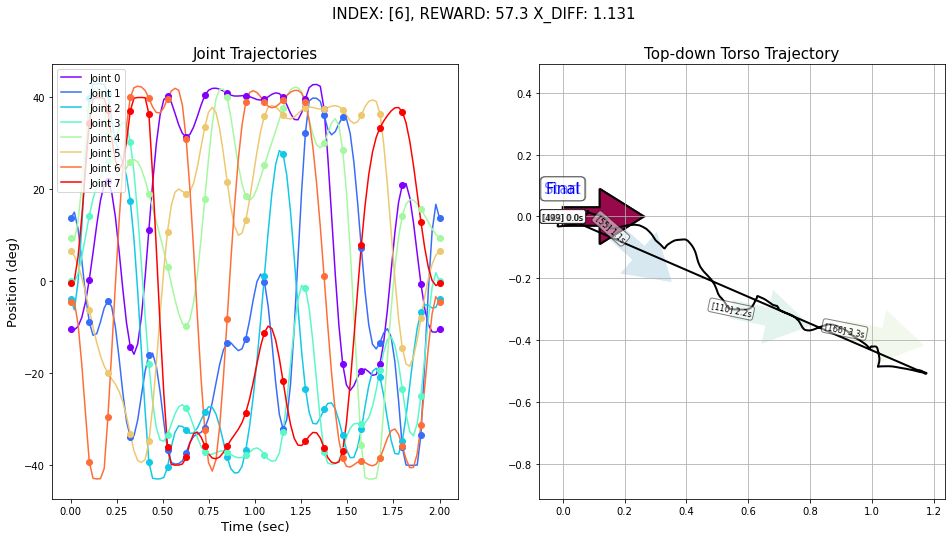

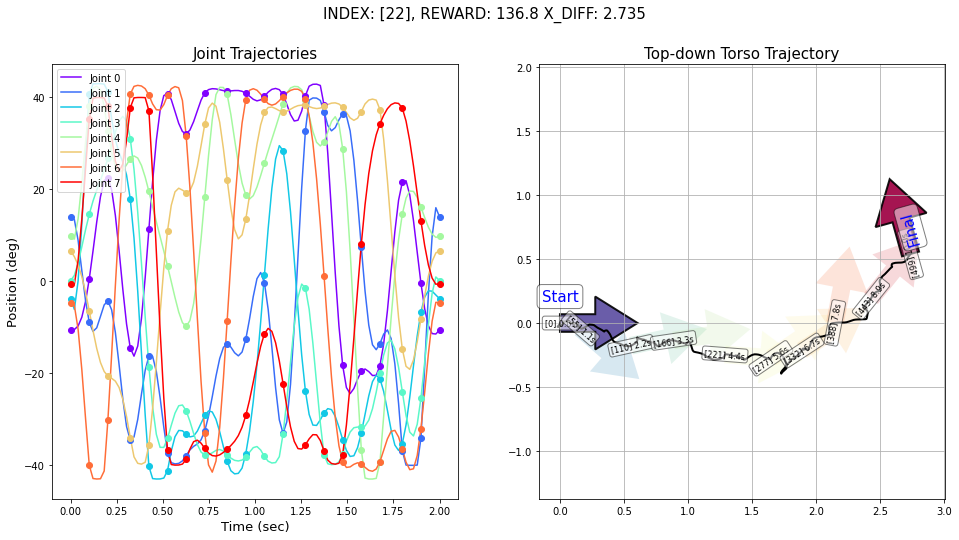

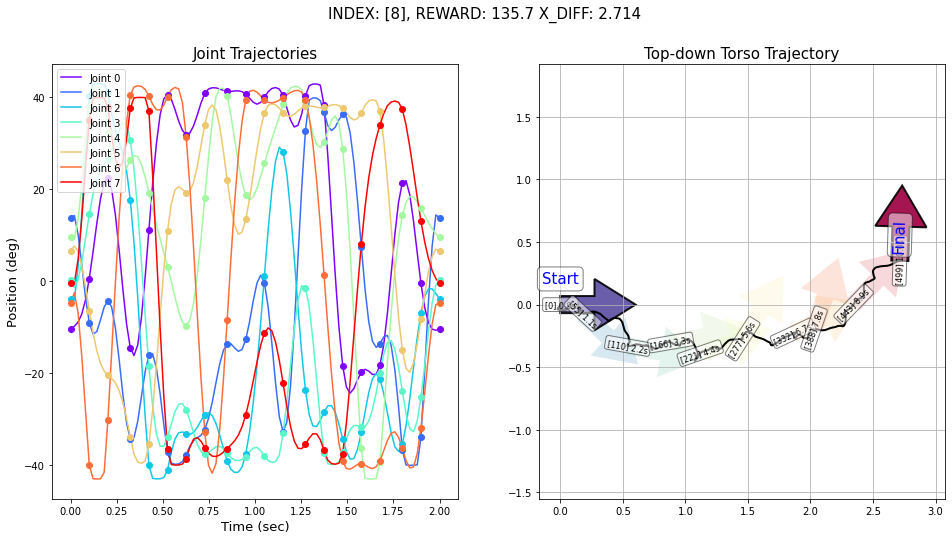

In [3]:

env = Snapbot4EnvClass(render_mode=None)
EVAL = eval_snapbot_from_network(env=env, dur_sec=2, embedding_num=32, n_anchor=20, max_repeat=5, folder=42, epoch=200,  condition=[0,1,0], RENDER=False, PLOT=False)

In [5]:
EVAL.DLPG.GQ.embedding.weight.data

tensor([[ 0.9286,  0.0429, -0.0934,  ...,  0.0011, -0.0150, -0.0311],
        [ 0.0071,  0.6444,  0.0163,  ...,  0.0421, -0.0176, -0.0206],
        [ 0.0528, -0.0904,  0.7842,  ...,  0.0707, -0.0951, -0.0798],
        ...,
        [-0.0297,  0.0223,  0.0224,  ...,  0.7784,  0.0496,  0.0903],
        [ 0.0377, -0.0471, -0.0227,  ...,  0.0614,  0.7704, -0.0067],
        [-0.0147, -0.0437, -0.0426,  ..., -0.0287, -0.0785,  0.7249]],
       device='cuda:0')

In [ ]:
EVAL.DLPG.VQ.embedding.weight.data[2]

In [ ]:
EVAL.DLPG.VQ.embedding.weight.data[23]